In [1]:
#PyTorch
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau


import collections
import random
import re

# Matplotlib
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
plt.style.use('fivethirtyeight')

In [88]:
class Vocab:  # @save
    """Vocabulary for text."""

    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        # Flatten a 2D list if needed
        if tokens and isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]

        # Count token frequencies
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                  reverse=True)

        # The list of unique tokens
        self.idx_to_token = list(sorted(set(['<unk>'] + reserved_tokens + [
            token for token, freq in self.token_freqs if freq >= min_freq])))
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}



    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if hasattr(indices, '__len__') and len(indices) > 1:
            return [self.idx_to_token[int(index)] for index in indices]
        return self.idx_to_token[indices]

    @property
    def unk(self):  # Index for the unknown token
        return self.token_to_idx['<unk>']


class TimeMachine(Dataset):
    def __init__(self, num_steps, num_train=10000, num_val=5000) -> None:
        corpus, self.vocab = self.build(self._download())
        array = torch.tensor([corpus[i:i+num_steps+1]
                            for i in range(len(corpus)-num_steps)])
        self.X, self.Y = array[:,:-1], array[:,1:]

    def _download(self):
        with open('data/timemachine.txt') as f:
            return f.read()

    def _preprocess(self, text):
        return re.sub('[^A-Za-z]+', ' ', text).lower()

    def _tokenize(self, text):
        return list(text)

    def build(self, raw_text, vocab=None):
        tokens = self._tokenize(self._preprocess(raw_text))
        if vocab is None:
            vocab = Vocab(tokens)
        corpus = [vocab[token] for token in tokens]
        return corpus, vocab

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


class MTFraEng(Dataset):
    def __init__(self, batch_size, num_steps=9, num_train=512, num_val=128) -> None:
        self.batch_size = batch_size
        self.num_steps = num_steps
        self.num_train = num_train
        self.num_val = num_val
        self.arrays, self.src_vocab, self.tgt_vocab = self._build_arrays(self._download())

    def _download(self):
        with open('data/fra-eng/fra.txt') as f:
            return f.read()

    def _preprocess(self, text):
        text = text.replace('\u202f', ' ').replace('\xa0', ' ')
        # Insert space between words and punctuation marks
        no_space = lambda char, prev_char: char in ',.!?' and prev_char != ' '
        out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
            for i, char in enumerate(text.lower())]
        return ''.join(out)

    def _tokenize(self, text, max_examples=None):
        src, tgt = [], []
        for i, line in enumerate(text.split('\n')):
            if max_examples and i > max_examples: break
            parts = line.split('\t')
            if len(parts) == 2:
                # Skip empty tokens
                src.append([t for t in f'{parts[0]} <eos>'.split(' ') if t])
                tgt.append([t for t in f'{parts[1]} <eos>'.split(' ') if t])
        return src, tgt

    def build(self, raw_text, vocab=None):
        tokens = self._tokenize(self._preprocess(raw_text))
        if vocab is None:
            vocab = Vocab(tokens)
        corpus = [vocab[token] for token in tokens]
        return corpus, vocab

    def _build_arrays(self, raw_text, src_vocab=None, tgt_vocab=None):
        def _build_array(sentences, vocab, is_tgt=False):
            pad_or_trim = lambda seq, t: (
                seq[:t] if len(seq) > t else seq + ['<pad>'] * (t - len(seq)))
            sentences = [pad_or_trim(s, self.num_steps) for s in sentences]
            if is_tgt:
                sentences = [['<bos>'] + s for s in sentences]
            if vocab is None:
                vocab = Vocab(sentences, min_freq=2)
            array = torch.tensor([vocab[s] for s in sentences])
            valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
            return array, vocab, valid_len
        src, tgt = self._tokenize(self._preprocess(raw_text),
                                self.num_train + self.num_val)
        src_array, src_vocab, src_valid_len = _build_array(src, src_vocab)
        tgt_array, tgt_vocab, _ = _build_array(tgt, tgt_vocab, True)
        return ((src_array, tgt_array[:,:-1], src_valid_len, tgt_array[:,1:]),
                src_vocab, tgt_vocab)

    def __len__(self):
        return len(self.arrays[0])

    def __getitem__(self, idx):
        return self.arrays[0][idx], self.arrays[1][idx], self.arrays[2][idx], self.arrays[3][idx]


In [90]:
data = MTFraEng(batch_size=3)
data_dl = DataLoader(data)

src, tgt, src_valid_len, label = next(iter(data_dl))
print('source:', src.type(torch.int32))

source: tensor([[59,  2,  3,  4,  4,  4,  4,  4,  4]], dtype=torch.int32)


In [3]:
data = TimeMachine(num_steps=10)
data_dl = DataLoader(data, batch_size=2)

raw_text = data._download()
text = data._preprocess(raw_text)
tokens = data._tokenize(text)

for X, Y in data_dl:
    print('X:', X, '\nY:', Y)
    break

X: tensor([[21,  9,  6,  0, 21, 10, 14,  6,  0, 14],
        [ 9,  6,  0, 21, 10, 14,  6,  0, 14,  2]]) 
Y: tensor([[ 9,  6,  0, 21, 10, 14,  6,  0, 14,  2],
        [ 6,  0, 21, 10, 14,  6,  0, 14,  2,  4]])


In [38]:
class LSTMScratch(nn.Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.num_inputs = num_inputs
        self.num_hiddens = num_hiddens
        self.sigma = sigma
        init_weight = lambda *shape: nn.Parameter(torch.randn(*shape) * sigma)
        triple = lambda: (init_weight(num_inputs, num_hiddens),
                          init_weight(num_hiddens, num_hiddens),
                          nn.Parameter(torch.zeros(num_hiddens)))
        self.W_xi, self.W_hi, self.b_i = triple()  # Input gate
        self.W_xf, self.W_hf, self.b_f = triple()  # Forget gate
        self.W_xo, self.W_ho, self.b_o = triple()  # Output gate
        self.W_xc, self.W_hc, self.b_c = triple()  # Input node

    def forward(self, inputs, H_C=None):
        if H_C is None:
            # Initial state with shape: (batch_size, num_hiddens)
            H = torch.zeros((inputs.shape[1], self.num_hiddens))
            C = torch.zeros((inputs.shape[1], self.num_hiddens))
        else:
            H, C = H_C
        outputs = []
        for X in inputs:
            I = torch.sigmoid(torch.matmul(X, self.W_xi) +
                            torch.matmul(H, self.W_hi) + self.b_i)
            F = torch.sigmoid(torch.matmul(X, self.W_xf) +
                            torch.matmul(H, self.W_hf) + self.b_f)
            O = torch.sigmoid(torch.matmul(X, self.W_xo) +
                            torch.matmul(H, self.W_ho) + self.b_o)
            C_tilde = torch.tanh(torch.matmul(X, self.W_xc) +
                            torch.matmul(H, self.W_hc) + self.b_c)
            C = F * C + I * C_tilde
            H = O * torch.tanh(C)
            outputs.append(H)
        return outputs, (H, C)

class RNNScratch(nn.Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01) -> None:
        super().__init__()

        self.num_hiddens = num_hiddens
        self.sigma = sigma
        self.W_xh = nn.Parameter(torch.randn(num_inputs, num_hiddens)*sigma)
        self.W_hh = nn.Parameter(torch.randn(num_hiddens, num_hiddens)*sigma)
        self.b_h = nn.Parameter(torch.zeros(num_hiddens))

    def forward(self, inputs, state=None):
        if state is None:
            state = torch.zeros((inputs.shape[1], self.num_hiddens))
        else:
            state = state
        outputs = []
        for X in inputs:
            state = torch.tanh(X @ self.W_xh + state @ self.W_hh + self.b_h)
            outputs.append(state)

        return outputs, state

class RNNLMScratch(nn.Module):
    def __init__(self, rnn, vocab_size, lr=0.01) -> None:
        super().__init__()
        self.rnn = rnn
        self.vocab_size = vocab_size
        self.lr = lr
        self.init_params()

    def init_params(self):
        self.W_hq = nn.Parameter(torch.randn(self.rnn.num_hiddens, self.vocab_size)*self.rnn.sigma)
        self.b_q = nn.Parameter(torch.zeros(self.vocab_size))

    def training_step(self, batch):
        l = nn.functional.cross_entropy(self(*batch[:-1]), batch[-1])
        # plt.plot...
        return l

    def validation_step(self, batch):
        l = nn.CrossEntropyLoss(self(*batch[:-1]), batch[-1])
        # plt.plot...
        return l

    def one_hot(self, X):
        return torch.nn.functional.one_hot(X.T, self.vocab_size).type(torch.float32)

    def output_layer(self, rnn_outputs):
        outputs = [H @ self.W_hq +  self.b_q for H in rnn_outputs]
        return torch.stack(outputs, 1)

    def forward(self, X, state=None):
        embs = self.one_hot(X)
        rnn_outputs, _ = self.rnn(embs, state)
        return self.output_layer(rnn_outputs)

    def loss_fn(self, logits, y):
        logits = logits.reshape((-1, 28))
        y = y.reshape((-1,))
        loss = nn.functional.cross_entropy(logits, y)
        return loss

    def predict(self, prefix, num_preds, vocab, device=None):
        state, outputs = None, [vocab[prefix[0]]]
        for i in range(len(prefix) + num_preds - 1):
            X = torch.tensor([[outputs[-1]]], device=device)
            embs = self.one_hot(X)
            rnn_outputs, state = self.rnn(embs, state)
            if i < len(prefix) - 1:  # Warm-up period
                outputs.append(vocab[prefix[i + 1]])
            else:  # Predict `num_preds` steps
                Y = self.output_layer(rnn_outputs)
                outputs.append(int(Y.argmax(axis=2).reshape(1)))
        return ''.join([vocab.idx_to_token[i] for i in outputs])


class RNN(nn.Module):  #@save
    def __init__(self, num_inputs, num_hiddens):
        super().__init__()
        self.num_inputs = num_inputs
        self.num_hiddens = num_hiddens
        self.rnn = nn.RNN(num_inputs, num_hiddens)

    def forward(self, inputs, H=None):
        return self.rnn(inputs, H)


class LSTM(nn.Module):
    def __init__(self, num_inputs, num_hiddens):
        super().__init__()
        self.num_inputs = num_inputs
        self.num_hiddens = num_hiddens
        self.rnn = nn.LSTM(num_inputs, num_hiddens)

    def forward(self, inputs, H_C=None):
        return self.rnn(inputs, H_C)

class RNNLM(RNNLMScratch):  #@save
    def init_params(self):
        self.linear = nn.LazyLinear(self.vocab_size)
    def output_layer(self, hiddens):
        return self.linear(hiddens).swapaxes(0, 1)
    def loss_fn(self, logits, y):
        logits = logits.reshape((-1, 28))
        y = y.reshape((-1,))
        loss = nn.functional.cross_entropy(logits, y)
        return loss


In [27]:
data = TimeMachine(num_steps=32)
data_dl = DataLoader(data, batch_size=256, shuffle=True)
lstm = LSTMScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLMScratch(lstm, vocab_size=len(data.vocab), lr=4)

In [28]:
x, y = next(iter(data_dl))

print (x.shape)

model(x).shape

torch.Size([256, 32])


torch.Size([256, 32, 28])

In [29]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.1)
lr = torch.logspace(-4,1,len(data_dl))
losses = torch.zeros(len(data_dl))
for step, batch in enumerate(data_dl):
    x, y = batch

    logits = model(x)

    loss = model.loss_fn(logits, y)
    losses[step] = loss.item()

    if step % 100 == 0:
        print (step, loss.item())

    optimizer = torch.optim.SGD(model.parameters(), lr=lr[step])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step

    
    #break

0 3.3322181701660156
100 3.3322181701660156
200 3.33221697807312
300 3.3322179317474365
400 3.3322181701660156
500 3.3322176933288574
600 3.3322184085845947


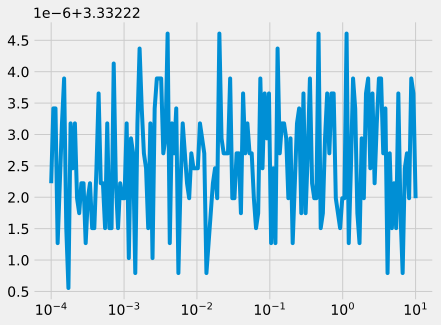

In [26]:
plt.semilogx(lr, losses)

In [53]:
data = TimeMachine(num_steps=32)
data_dl = DataLoader(data, batch_size=1024, shuffle=True)

lstm = LSTM(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLM(lstm, vocab_size=len(data.vocab), lr=4)

x, y = next(iter(data_dl))
print (x.shape)
model(x).shape


torch.Size([1024, 32])


/Users/jsmidt/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([1024, 32, 28])

In [54]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.1)
optimizer = torch.optim.SGD(model.parameters(), lr=4.0)

lr = torch.logspace(-4,2,len(data_dl))
losses = torch.zeros(len(data_dl))
for epoch in range(25):
    for step, batch in enumerate(data_dl):
        x, y = batch

        logits = model(x)

        loss = model.loss_fn(logits, y)
        losses[step] = loss.item()

        #if step % 100 == 0:
        #    print (step, loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step
    print (epoch, loss.item())
    

0 3.305590867996216
1 3.3068604469299316
2 3.306445598602295
3 3.3076159954071045
4 3.3077876567840576
5 3.3068480491638184
6 3.3086726665496826
7 3.3074262142181396
8 3.3072445392608643
9 3.306605100631714
10 3.3078973293304443
11 3.3059463500976562
12 3.3086936473846436
13 3.3067145347595215
14 3.307955741882324
15 3.307950735092163
16 3.3067288398742676
17 3.30788254737854
18 3.306340456008911


KeyboardInterrupt: 

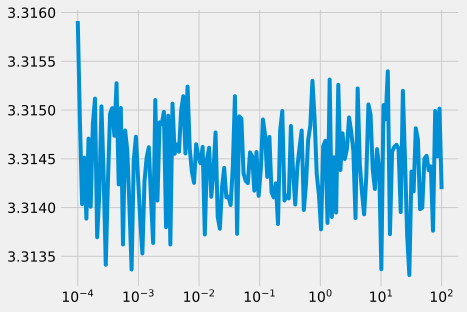

In [50]:
plt.semilogx(lr, losses)

Model "RNNLM" has 8860 parameters
Epoch   0 has train loss 3.3153
Epoch   1 has train loss 2.7693
Epoch   2 has train loss 2.5084
Epoch   3 has train loss 2.3045
Epoch   4 has train loss 2.2154
Epoch   5 has train loss 2.1402
Epoch   6 has train loss 2.1014
Epoch   7 has train loss 2.0617
Epoch   8 has train loss 2.0118
Epoch   9 has train loss 1.9761
Epoch  10 has train loss 1.9414
Epoch  11 has train loss 1.9048
Epoch  12 has train loss 1.9037
Epoch  13 has train loss 1.8580
Epoch  14 has train loss 1.8321
Epoch  15 has train loss 1.7931
Epoch  16 has train loss 1.7899
Epoch  17 has train loss 1.7716
Epoch  18 has train loss 1.7492
Epoch  19 has train loss 1.7496
Epoch  20 has train loss 1.7323
Epoch  21 has train loss 1.7382
Epoch  22 has train loss 1.7207
Epoch  23 has train loss 1.7028
Epoch  24 has train loss 1.6878
Epoch  25 has train loss 1.6848


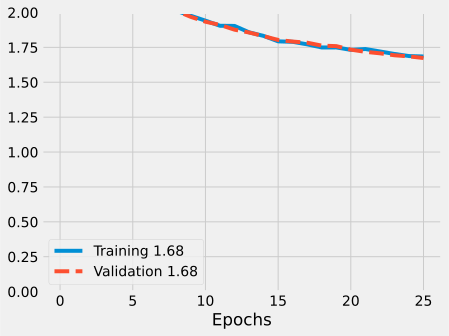

In [64]:
device = "cpu"
max_epochs = 25
train_lr = False
LR = 1e-3
batch_size=256

try:
    del(model)
    del(x)
    del(y)
    del(vx)
    del(vy)
except:
    pass


data = TimeMachine(num_steps=32*2)
data_dl = DataLoader(data, batch_size=1024, shuffle=True)
#rnn = RNN(num_inputs=len(data.vocab), num_hiddens=32)
#model = RNNLM(rnn, vocab_size=len(data.vocab), lr=1) 

lstm = LSTM(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLM(lstm, vocab_size=len(data.vocab), lr=4)


# Initialize model and get first statistics using validation data
x, y = next(iter(data_dl))
x, y = x.to(device), y.to(device)
val_logits = model(x)

# Number of parameters
print(f'Model "{model.__class__.__name__}" has {sum([p.numel() for p in model.parameters()])} parameters')

# Initial loss
val_loss = model.loss_fn(val_logits, y).item()
#val_acc = model.accuracy(val_logits, y).item()
print(f'Epoch {0:>3d} has train loss {val_loss:.4f}')


N = len(data_dl)
lr = torch.logspace(-6, -2, N)
losses = torch.zeros(N)
min_loss = 9999999.
min_epoch = 0
if train_lr is False:
    model.optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
    scheduler = ReduceLROnPlateau(model.optimizer, 'min', factor=0.1, verbose=True)
epochs = [0]
ptloss = [val_loss]
pvloss = [val_loss]
#pvacc = [val_acc]
for epoch in range(1, max_epochs+1):
    model.train()
    if epoch % 400 == 0:
        LR = LR/2.0
        print (f'Changing LR to {LR}')
        model.optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
    for step, batch in enumerate(data_dl):

        # Get Minibatch
        x, y = batch
        x, y = x.to(device), y.to(device)

        # Get logits
        train_logits = model(x)

        # Get loss
        train_loss = model.loss_fn(train_logits, y)
        losses[step] = train_loss.item()

        # Update
        if train_lr:
            model.optimizer = torch.optim.AdamW(model.parameters(), lr=lr[step])
        model.optimizer.zero_grad(set_to_none=True)
        train_loss.backward()
        model.optimizer.step()

        #if step % 20 == 0:
        #    print(f'step {step} has loss {train_loss.item()}')
    
    if train_lr:
        break
    # Evaluate for epoch
    model.eval()
    with torch.no_grad():
        vx, vy = next(iter(data_dl))
        vx, vy = vx.to(device), vy.to(device)
        val_logits = model(vx)
        val_loss = model.loss_fn(val_logits, vy).item()
        #val_acc = model.accuracy(val_logits, vy).item()
        epochs.append(epoch)
        ptloss.append(train_loss.item())
        pvloss.append(val_loss)
        #pvacc.append(val_acc)
        scheduler.step(val_loss)

        # Early Stopping
        if val_loss < min_loss:
            min_loss = val_loss
            min_epoch = epoch
        else:
            if epoch - 20 > min_epoch:
                break

    if epoch % 1 == 0:
        print(f'Epoch {epoch:>3d} has train loss {train_loss.item():.4f}')

    #break


if train_lr is False:
    # Get final training loss:
    model.eval()
    ftloss = []
    for batch in data_dl:
        # Get Minibatch
        x, y = batch
        x, y = x.to(device), y.to(device)

        # Get logits
        train_logits = model(x)

        # Get loss
        train_loss = model.loss_fn(train_logits, y)
        ftloss.append(train_loss)

    fvloss = []
    fvacc = []
    for batch in data_dl:
        # Get Minibatch
        x, y = batch
        x, y = x.to(device), y.to(device)

        # Get logits
        val_logits = model(x)

        # Get loss
        val_loss = model.loss_fn(val_logits, y)
        #val_acc = model.accuracy(val_logits, y).item()
        fvloss.append(val_loss)
        #fvacc.append(val_acc)


    ftloss = torch.tensor(ftloss).mean().item()
    fvloss = torch.tensor(fvloss).mean().item()
    #fvacc = torch.tensor(fvacc).mean().item()


    # Plot
    plt.figure()
    #epochs = torch.arange(max_epochs + 1).detach()
    plt.plot(epochs, ptloss, 'C0-', label=f'Training {ftloss:.2f}')
    plt.plot(epochs, pvloss, 'C1--', label=f'Validation {fvloss:.2f}')
    #plt.plot(epochs, pvacc, 'C2:', label=f'Accuracy {fvacc:.2f}')
    plt.ylim(0,2)
    plt.xlabel('Epochs')
    plt.legend();
else:
    plt.semilogx(lr, losses)

In [65]:
model.predict('hello', 50, data.vocab)

'hellough the stance the stance the stance the stance th'